데이터 : 스마트폰, 이마, 색소침착 데이터<br>
0등급과 2등급의 2가지라벨을 가지고 이진분류 모델 개발<br>
04.이진분류_01.ipynb를 기반으로 정확도 및 손실 개선 작업 진행

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import pickle
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# 학습 데이터 준비 1. 스마트폰, 전면, 이마, 메타데이터 전체
path = "/content/drive/MyDrive/Human_Final_Project/Data/Train_Data_Sets_02.pkl"
with open(path, "rb") as pickle_file:
    train_data_sets = pickle.load(pickle_file)
    print("데이터 로드 완료!!")

데이터 로드 완료!!


In [5]:
def data_selector(data_sets, target):
    """
    data_sets : {'Images': dict, 'Metadata': dict}
    target : [0, 2] 리스트형식으로 입력
    """

    # 원하는 타겟의 파일이름을 저장하기 위한 리스트 생성
    keys = []
    for idx, file_name in enumerate(data_sets["Metadata"]):
        pig = data_sets["Metadata"][file_name]['annotations']['forehead_pigmentation']
        # 타겟리스트안에 있는 파일명만 키에 저장
        if pig in target:
            keys.append(file_name)

    #값을 저장할 딕셔너리 생성
    selected_data = {}
    image = {}
    meta = {}

    #앞에서 생성한 키를 이용하여 데이터셋에서 파일명에 해당하는 데이터 추출
    for id in keys:
        image[id] = data_sets["Images"][id]
        meta[id] = data_sets["Metadata"][id]
    selected_data["Images"] = image
    selected_data["Metadata"] = meta

    from collections import Counter

    # 전체 데이터셋의 타겟 분포 확인
    targets = [metadata["annotations"]["forehead_pigmentation"] for metadata in selected_data["Metadata"].values()]
    target_distribution = Counter(targets)

    # 분포 출력
    print("Target Distribution (Class Count):")
    for target, count in sorted(target_distribution.items()):
        print(f"Class {target}: {count}")

    classes = sorted(target_distribution.keys())
    counts = [target_distribution[c] for c in classes]

    plt.bar(classes, counts, tick_label=[f"Class {c}" for c in classes])
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Target Distribution")
    plt.show()

    return selected_data

Target Distribution (Class Count):
Class 0: 175
Class 2: 163


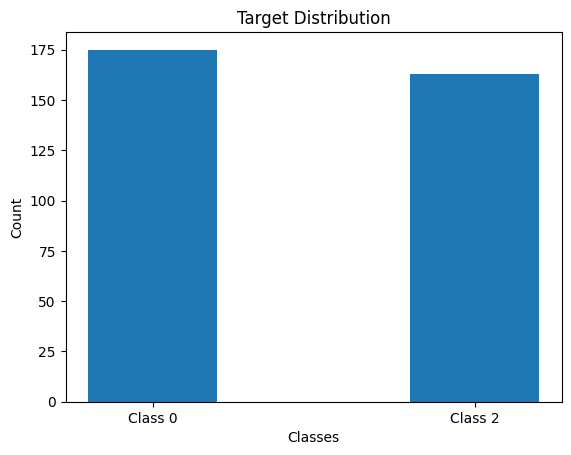

In [6]:
train_data = data_selector(train_data_sets, [0, 2])

In [7]:
# 검증 데이터 준비 1. 스마트폰, 전면, 이마, 메타데이터 전체
path = "/content/drive/MyDrive/Human_Final_Project/Data/Val_Data_Sets_02.pkl"
with open(path, "rb") as pickle_file:
    val_data_sets = pickle.load(pickle_file)
    print("데이터 로드 완료!!")

데이터 로드 완료!!


Target Distribution (Class Count):
Class 0: 21
Class 2: 21


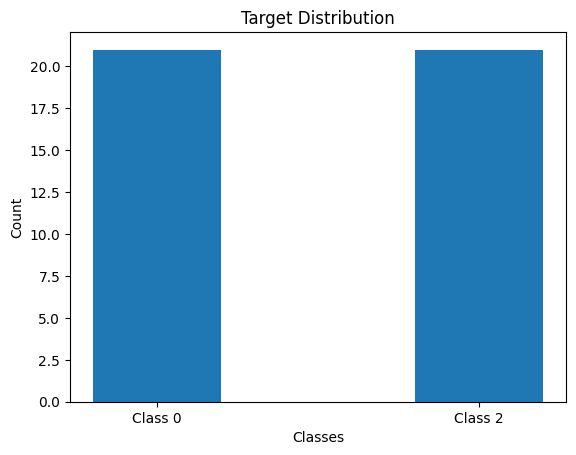

['0013_03_F_01',
 '0061_03_F_01',
 '0072_03_F_01',
 '0111_03_F_01',
 '0117_03_F_01']

In [8]:
val_data = data_selector(val_data_sets, [0, 2])
list(val_data['Metadata'].keys())[:5]

In [9]:
# 데이터 준비 1.
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])

In [22]:
class CustomDataset(Dataset):
    def __init__(self, data_sets, transform=transform):
        """
        Args:
            data_sets (dict): {'Images': dict, 'Metadata': dict}
            transform (callable, optional): 이미지에 적용할 변환 함수
        """
        self.images = data_sets['Images']
        self.metadata = data_sets['Metadata']
        self.keys = list(self.images.keys())  # 공통 키 목록
        self.transform = transform

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        image = self.images[key]

        # BGR에서 RGB로 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        target = torch.tensor(self.metadata[key]['annotations']['forehead_pigmentation'], dtype=torch.float32)  # 타겟 텐서
        return image, target


In [23]:
#데이터셋 생성
dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)

In [24]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

In [14]:
class SkinNet(nn.Module):
    def __init__(self):
        super(SkinNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.dropbout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  # 수정된 입력 크기
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)  # Flatten the tensor

        x = F.relu(self.fc1(x))
        x = self.dropbout(x)

        x = F.relu(self.fc2(x))
        x = self.dropbout(x)

        x = self.fc3(x)
        return x


In [15]:
model = SkinNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

print(model)

SkinNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropbout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=

In [18]:
# 학습 함수
def train(model, train_loader, optimizer, criterion, device):
    loss_total = 0
    correct_total = 0
    model.train()
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device).long()

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # 누적 손실 및 정확도 계산
        loss_total += loss.item()
        predicted_values = output.max(1, keepdim=True)[1]
        correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
        correct_total += correct

    loss_total /= len(train_loader)  # 평균 손실
    accuracy = correct_total / len(train_loader.dataset)  # 정확도

    print(f"Epoch Finished - Loss: {loss_total:.4f}, Accuracy: {accuracy:.4f}")

    return loss_total, accuracy

In [19]:
# 평가 함수
def evaluate(model, test_loader, criterion, device, val_dataset):
    loss_total = 0
    correct_total = 0
    model.eval()  # 평가 모드
    with torch.no_grad():  # 가중치 업데이트 비활성화
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).long()
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss

            predicted_values = output.max(1, keepdim=True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
            correct_total += correct

    loss_total /= len(test_loader)  # 평균 손실
    accuracy = correct_total / len(val_dataset)  # 정확도

    return loss_total, accuracy

In [20]:
# 손실 및 정확도 시각화
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [25]:
# 히스토리 초기화
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

# 학습 및 평가 실행
for epoch in range(100):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device, val_dataset)

    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch : {epoch + 1}, val_Loss: {val_loss:.4f}, val_Accuracy: {val_accuracy:.4f}\n")

Epoch Finished - Loss: 1.0696, Accuracy: 0.4053
Epoch : 1, val_Loss: 1.0561, val_Accuracy: 0.5000

Epoch Finished - Loss: 0.9725, Accuracy: 0.5089
Epoch : 2, val_Loss: 0.9417, val_Accuracy: 0.5714

Epoch Finished - Loss: 0.9043, Accuracy: 0.5621
Epoch : 3, val_Loss: 0.8929, val_Accuracy: 0.5952

Epoch Finished - Loss: 0.8584, Accuracy: 0.6065
Epoch : 4, val_Loss: 0.8365, val_Accuracy: 0.6667

Epoch Finished - Loss: 0.8145, Accuracy: 0.5917
Epoch : 5, val_Loss: 0.8154, val_Accuracy: 0.5714

Epoch Finished - Loss: 0.8047, Accuracy: 0.6095
Epoch : 6, val_Loss: 0.7884, val_Accuracy: 0.6429

Epoch Finished - Loss: 0.7526, Accuracy: 0.6420
Epoch : 7, val_Loss: 0.7846, val_Accuracy: 0.5952

Epoch Finished - Loss: 0.7554, Accuracy: 0.6420
Epoch : 8, val_Loss: 0.7660, val_Accuracy: 0.5952

Epoch Finished - Loss: 0.7480, Accuracy: 0.5917
Epoch : 9, val_Loss: 0.7705, val_Accuracy: 0.5952

Epoch Finished - Loss: 0.7418, Accuracy: 0.6065
Epoch : 10, val_Loss: 0.7680, val_Accuracy: 0.5952

Epoch Fin

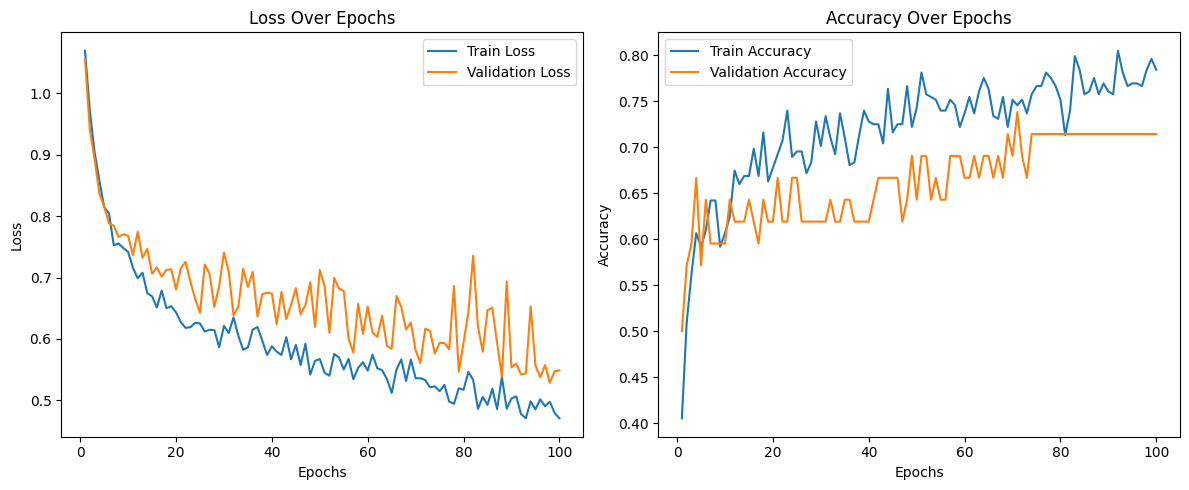

In [26]:
# 학습 결과 시각화
plot_history(history)

In [27]:
# 히스토리 초기화
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

# 학습 및 평가 실행2
for epoch in range(100):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device, val_dataset)

    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch : {epoch + 1}, val_Loss: {val_loss:.4f}, val_Accuracy: {val_accuracy:.4f}\n")

Epoch Finished - Loss: 0.5120, Accuracy: 0.7337
Epoch : 1, val_Loss: 0.6402, val_Accuracy: 0.7143

Epoch Finished - Loss: 0.5279, Accuracy: 0.7544
Epoch : 2, val_Loss: 0.5910, val_Accuracy: 0.7143

Epoch Finished - Loss: 0.4764, Accuracy: 0.7722
Epoch : 3, val_Loss: 0.5927, val_Accuracy: 0.7143

Epoch Finished - Loss: 0.4917, Accuracy: 0.7544
Epoch : 4, val_Loss: 0.5362, val_Accuracy: 0.7143

Epoch Finished - Loss: 0.4867, Accuracy: 0.7751
Epoch : 5, val_Loss: 0.6548, val_Accuracy: 0.7143

Epoch Finished - Loss: 0.4942, Accuracy: 0.7781
Epoch : 6, val_Loss: 0.5300, val_Accuracy: 0.7143

Epoch Finished - Loss: 0.4787, Accuracy: 0.8077
Epoch : 7, val_Loss: 0.5291, val_Accuracy: 0.7143

Epoch Finished - Loss: 0.4533, Accuracy: 0.8047
Epoch : 8, val_Loss: 0.5624, val_Accuracy: 0.7143

Epoch Finished - Loss: 0.4945, Accuracy: 0.7722
Epoch : 9, val_Loss: 0.6376, val_Accuracy: 0.7143

Epoch Finished - Loss: 0.4952, Accuracy: 0.7722
Epoch : 10, val_Loss: 0.5960, val_Accuracy: 0.7143

Epoch Fin

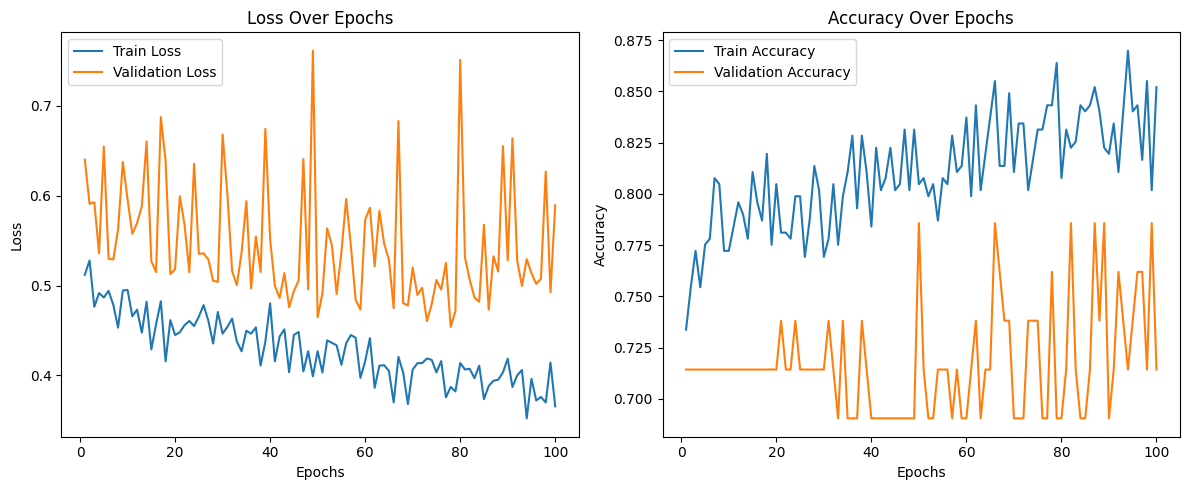

In [28]:
# 학습 결과 시각화
plot_history(history)

In [30]:
# 히스토리 초기화
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

# 학습 및 평가 실행3
for epoch in range(100):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device, val_dataset)

    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch : {epoch + 1}, val_Loss: {val_loss:.4f}, val_Accuracy: {val_accuracy:.4f}\n")

Epoch Finished - Loss: 0.2731, Accuracy: 0.8994
Epoch : 1, val_Loss: 0.4286, val_Accuracy: 0.7857

Epoch Finished - Loss: 0.2822, Accuracy: 0.8905
Epoch : 2, val_Loss: 0.5513, val_Accuracy: 0.8095

Epoch Finished - Loss: 0.3168, Accuracy: 0.8757
Epoch : 3, val_Loss: 0.6986, val_Accuracy: 0.8095

Epoch Finished - Loss: 0.2998, Accuracy: 0.8757
Epoch : 4, val_Loss: 0.4437, val_Accuracy: 0.8095

Epoch Finished - Loss: 0.2751, Accuracy: 0.9112
Epoch : 5, val_Loss: 0.4462, val_Accuracy: 0.8333

Epoch Finished - Loss: 0.2697, Accuracy: 0.9201
Epoch : 6, val_Loss: 0.4341, val_Accuracy: 0.8095

Epoch Finished - Loss: 0.2964, Accuracy: 0.8639
Epoch : 7, val_Loss: 0.4615, val_Accuracy: 0.8095

Epoch Finished - Loss: 0.2603, Accuracy: 0.9083
Epoch : 8, val_Loss: 0.4542, val_Accuracy: 0.8095

Epoch Finished - Loss: 0.2938, Accuracy: 0.8876
Epoch : 9, val_Loss: 0.4545, val_Accuracy: 0.8095

Epoch Finished - Loss: 0.3242, Accuracy: 0.8817
Epoch : 10, val_Loss: 0.4716, val_Accuracy: 0.8095

Epoch Fin